# Imports & Class Objects

In [1]:
import pathlib
import imageio
import numpy as np
import torch
import torch.nn as nn
import torchvision
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import random
from skimage import io
from torchvision import transforms
import os
from torch.utils.data import Dataset, DataLoader
import cv2
import google
from torchvision.transforms.transforms import CenterCrop
google.colab.drive.mount('/content/drive', force_remount=True)
drive = pathlib.Path('./drive/MyDrive') / 'MLDL_DRIVE_seg_project'



Mounted at /content/drive


In [2]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(12138)
torch.manual_seed(12138)

## DataLoader

In [3]:
database = drive / 'DRIVE_VAL'
class DriveDataset(Dataset):

    def __init__(self,
                 input_dir,
                 mode,
                 transform = None):

        self.mode = mode
        self.transform = transform
        try:
            if self.mode == 'train':
                self.data_dir = os.path.join(input_dir, 'training')
            elif self.mode == 'val':
                self.data_dir = os.path.join(input_dir, 'validation')
            elif self.mode == 'test':
                self.data_dir = os.path.join(input_dir, 'test')
        except ValueError:
            print('op should be either train, val or test!')

    def __len__(self):

        return len(os.listdir(f"{self.data_dir}/images"))

    def __getitem__(self,
                    idx):
        
        self.image_list, self.mask_list = self.get_data_name_list(self.data_dir)
        self.image_name = self.image_list[idx].split('/')[-1]
        self.mask_name = self.mask_list[idx].split('/')[-1]
        # print(self.image_list)

        # img = io.imread(self.image_list[idx])
        img = cv2.imread(self.image_list[idx],cv2.IMREAD_UNCHANGED)
        # BGR2RGB
        img=img[...,::-1]

        mask = io.imread(self.mask_list[idx])
        
        ## Transform image and mask
        if self.transform:
            img = self.normalize(img)
            mask = self.normalize(mask)
            img, mask = self.img_transform(img, mask)
            # img = transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))(img)
  
        return img, mask

    def img_transform(self,
                      img,
                      mask):

        ## Apply Transformations to Image and Mask
        img = img.transpose(2,0,1)
        # 3 channel mask for combine
        new_mask = np.zeros((img.shape[0],img.shape[1], img.shape[2]))
        new_mask[0:3,:,:] = mask[:,:]

        img = torch.as_tensor(img.copy()).unsqueeze(0) # cast NumPy array to Torch tensor
        mask = torch.as_tensor(new_mask.copy()).unsqueeze(0)
        combined = torch.cat([img, mask], dim=0)

        combined = self.transform(combined)

        image2 = combined[0,0:3,:,:]
        # only one channel mask is needed after cat
        mask2 = combined[1,0,:,:]
        img, mask = image2, mask2

 
        return img, mask

    def get_data_name_list(self, data_dir):

        image_path = os.path.join(data_dir, 'images')
        mask_path = os.path.join(data_dir, '1st_manual')

        image_list = [os.path.join(image_path, image) for image in sorted(os.listdir(image_path))]
        mask_list = [os.path.join(mask_path, mask) for mask in sorted(os.listdir(mask_path))]

        return image_list, mask_list 

    def normalize(self, img):
        return (img-img.min())/(img.max()-img.min())

In [4]:
img_transform = transforms.Compose([transforms.RandomCrop([512,512]),
        transforms.RandomVerticalFlip(0.5),transforms.RandomHorizontalFlip(0.5)
    ])
# without random crop to remove randomness
img_transform = transforms.Compose([transforms.CenterCrop([256,256]),
    transforms.RandomVerticalFlip(0.5),transforms.RandomHorizontalFlip(0.5)
])

device = torch.device('cuda')
train_batch_size = 3
validation_batch_size = 3

## Initialize Dataloaders
train_dataset=DriveDataset(input_dir=database, mode="train",transform=img_transform)
validation_dataset=DriveDataset(input_dir=database, mode="val",transform=img_transform)
test_dataset=DriveDataset(input_dir=database, mode="test",transform=img_transform)
# train_dataset = CustomizedDataset(database,'train',img_transform,img_transform)
# validation_dataset = CustomizedDataset(database,'validation',img_transform,img_transform)
# test_dataset = CustomizedDataset(database,'test',img_transform,img_transform)

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=0, verbose=False, delta=0, save_path=None):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.save_path = save_path
        if self.save_path:
          if not os.path.exists(self.save_path):
            os.mkdir(self.save_path)

    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            if self.save_path:
              self.save_checkpoint(val_loss, model)
        elif score >= self.best_score + self.delta:
            self.counter += 1
            # if self.counter % 1 == 0:
            #     print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            if self.save_path:
              print('++++++++++saving model...++++++++++')
              self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print('=='*50)
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            print('=='*50)
        torch.save(model.state_dict(), os.path.join(self.save_path,'model_YZ.pth'))	
        self.val_loss_min = val_loss
        print(f'saveing model done... validation loss is: {self.val_loss_min:.6f}')

In [6]:
def display_data(image,mask):
        image = train_dataset.normalize(image)
        print(image.max(),image.min())
        plt.imshow(image[0,:,:,:].numpy().transpose(1,2,0))
        plt.figure()
        plt.imshow(mask[0,:,:])
        plt.show()

In [7]:
early_stopping = EarlyStopping(patience=20, verbose=True)
def Train(model, path, display=False):
    random.seed(12138)
    torch.manual_seed(12138)
    # transforms.RandomCrop for small patches
    img_transform = transforms.Compose([transforms.RandomCrop([512,512]),
        transforms.RandomVerticalFlip(0.5),transforms.RandomHorizontalFlip(0.5)
    ])

    # hyperparameters
    device = torch.device('cuda')
    train_batch_size = 3
    validation_batch_size = 3
    n_classes = 1 # binary mask
    model = model().to(device)
    num_epochs = 500
    learning_rate = 0.01
    # learning_rate = 1e-4

    ## Initialize Dataloaders
    train_dataset=DriveDataset(input_dir=database, mode="train",transform=img_transform)
    validation_dataset=DriveDataset(input_dir=database, mode="val",transform=img_transform)
    test_dataset=DriveDataset(input_dir=database, mode="test")
    # train_dataset = CustomizedDataset(database,'train',img_transform,img_transform)
    # validation_dataset = CustomizedDataset(database,'validation',img_transform,img_transform)
    # test_dataset = CustomizedDataset(database,'test',img_transform,img_transform)    

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    # train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    # validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
    # test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, worker_init_fn=seed_worker, generator=g)
    
    ## Initialize Optimizer and Learning Rate Scheduler
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=5e-4)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
    
    # loss function 
    cost = nn.BCEWithLogitsLoss()

    losses_train = []
    losses_val = []
    print("Start Training...")
    ## Start training 
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_train = 0
        loss_val = 0
        ##############Training##############
        for image, mask in train_dataloader:
            image = image.float()
            mask = mask.float()
            if display:
              display_data(image,mask)
              break
            optimizer.zero_grad()
            predictions = model(image.to(device)).squeeze(1)
            loss = cost.forward(predictions,mask.to(device))
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        # scheduler.step()
        # loss for each batch 
        mean_train_loss = loss_train/ len(train_dataloader)
        losses_train.append(mean_train_loss)
        if (epoch+1) % 10 == 0:
            print('Training loss:', losses_train[-1])
    
        ##############Validation##############
        model.eval()
        for img, label in validation_dataloader:
            img = img.to(device).float()
            label = label.to(device).float()
            pred = model(img).squeeze(1)
            loss = cost.forward(pred,label)
            loss_val += loss.item()
        mean_val_loss = loss_train/ len(validation_dataloader)
        losses_val.append(mean_val_loss)
        if (epoch+1) % 10 == 0:
            print('Validation loss:', losses_val[-1])

        early_stopping(mean_val_loss, model)
        if early_stopping.early_stop:
            print('++++++++++Early Stopping...++++++++++')
            break

    checkpoint = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'losses_train': losses_train,
        'losses_val': losses_val}
    torch.save(checkpoint, drive / path)

In [8]:
def dice_score_image(prediction, target, n_classes):

    smooth = 1e-7
    dice_classes = np.zeros(n_classes)
    # print(prediction.shape,target.shape)

    prediction = prediction.flatten(start_dim=2, end_dim=3)
    target = target.unsqueeze(1).flatten(start_dim=2, end_dim=3)
    for cl in range(n_classes):

        TP = (prediction[:,cl,:]*target[:,cl,:]).sum(dim=1)
        DEN = (prediction[:,cl,:] + target[:,cl,:]).sum(dim = 1)

        dice_classes[cl] = ((2 * TP + smooth)/ (DEN+smooth)).mean()
        
    return dice_classes.mean()

def dice_score_dataset(model, dataloader, num_classes, use_gpu=False):
    ## Number of Batches and Cache over Dataset
    n_batches = len(dataloader)
    scores = np.zeros(n_batches)
    ## Evaluate
    model.eval()
    idx = 0
    for data in dataloader:
        ## Format Data
        img, target = data
        img = img.float()
        target = target.float()
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        ## Make Predictions
        out = model(img)
        n_classes = out.shape[1]
        # prediction = torch.argmax(out, dim=1)
        out = nn.Sigmoid()(out)
        # print(out.max(),out.min())
        prediction = out>0.5
        scores[idx] = dice_score_image(prediction, target, n_classes)
        idx += 1
    ## Average Dice Score Over Images
    m_dice = scores.mean()
    return m_dice

# mdice = dice_score_dataset(model_trained, train_dataloader, 1,use_gpu=True)
# print(mdice)

In [9]:
def normalize(img):
    return (img-img.min())/(img.max()-img.min())

def show_image(model, path, dataset):
    # without random crop to remove randomness
    img_transform = transforms.Compose([transforms.CenterCrop([512,512]),
        transforms.RandomVerticalFlip(0),transforms.RandomHorizontalFlip(0)
    ])

    device = torch.device('cuda')
    train_batch_size = 3
    validation_batch_size = 3

    ## Initialize Dataloaders
    train_dataset=DriveDataset(input_dir=database, mode="train",transform=img_transform)
    validation_dataset=DriveDataset(input_dir=database, mode="val",transform=img_transform)
    test_dataset=DriveDataset(input_dir=database, mode="test",transform=img_transform)
    # train_dataset = CustomizedDataset(database,'train',img_transform,img_transform)
    # validation_dataset = CustomizedDataset(database,'validation',img_transform,img_transform)
    # test_dataset = CustomizedDataset(database,'test',img_transform,img_transform)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=False)
    validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    # train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    # validation_dataloader = DataLoader(validation_dataset, batch_size=validation_batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)
    # test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, worker_init_fn=seed_worker, generator=g)

    if dataset == 'train':
        dataloader = train_dataloader
    elif dataset == 'validation':
        dataloader = validation_dataloader
    else:
        dataloader = test_dataloader

    checkpoint = torch.load( drive / path)
    device = 'cuda'
    model_trained = model(nclass=1).to(device)
    model_trained.load_state_dict(checkpoint['model'])
    losses_train = checkpoint['losses_train']
    losses_val = checkpoint['losses_val']
    # print(model_pretrain.oput)
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(losses_train, 'C0')
    ax.set_ylabel('Loss',fontsize = 18)
    # ax2 = ax.twinx()
    ax.plot(losses_val, 'C1')
    ax.legend(['Train loss','Validation loss'],fontsize = 16)
    # ax.set_ylabel('Validation Loss', c='C1', fontweight='bold')
    # ax2.spines['right'].set_position(('axes', 1 + 0.3))
    ax.set_xlabel('Epoch',fontsize = 18)
    ax.set_title('Losses w.r.t epoch',fontweight='bold', fontsize = 20)
    plt.show()

    nimages = 4
    fig, axs = plt.subplots(nrows=3, ncols=nimages, figsize=(nimages*3,3*3), subplot_kw={'xticks': [], 'yticks': []})
    axs[0,0].set_ylabel('image')
    axs[1,0].set_ylabel('mask')
    axs[2,0].set_ylabel('Prediction')
    i = 0
    with torch.no_grad():
        model_trained.eval()
        for images, masks in test_dataloader: 
            if i >= nimages:
                break
            images = images.float()
            masks = masks.float()
            predictions = model_trained(images.to(device))
            for image, mask, prediction in zip(images, masks, predictions):
                if i >= nimages:
                    break
                image = image.numpy().transpose(1,2,0)
                prediction = normalize(prediction)
                prediction = prediction.cpu().numpy()[0,:,:]>0.5
                axs[0,i].imshow(image)
                axs[1,i].imshow(mask)
                axs[2,i].imshow(prediction)
                axs[0,i].imshow(image)
                axs[1,i].imshow(mask)
                axs[2,i].imshow(prediction)
                i += 1

    #Dice Score
    mdice = dice_score_dataset(model_trained, train_dataloader, 1,use_gpu=True)
    print('train_dice score',mdice)
    mdice = dice_score_dataset(model_trained, test_dataloader, 1,use_gpu=True)
    print('test_dice score',mdice)

# U-Net Baseline

In [15]:
# With nn.Upsample, nn.ReLU, 4 downsample and the bottleneck features = 1024
# More original one 
class UNet_v1(nn.Module):

    def __init__(self, nchannel=3, nclass=1):
        super().__init__()
        self.iput = self.conv(nchannel, 64)
        self.maxpool = torch.nn.MaxPool2d(2)
        self.enc1 = self.conv(64, 128)
        self.enc2 = self.conv(128, 256)
        self.enc3 = self.conv(256, 512)
        self.enc4 = self.conv(512, 1024 // 2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv(1024, 512 // 2)
        self.dec2 = self.conv(512, 256 // 2)
        self.dec3 = self.conv(256, 128 // 2)
        self.dec4 = self.conv(128, 64)
        self.oput = torch.nn.Conv2d(64, nclass, kernel_size=1)

    def forward(self, x):
        x1 = self.iput(x)  # input
        # encoder layers
        x2 = self.maxpool(x1)
        x2 = self.enc1(x2)
        x3 = self.maxpool(x2)
        x3 = self.enc2(x3)
        x4 = self.maxpool(x3)
        x4 = self.enc3(x4)
        x5 = self.maxpool(x4)
        x5 = self.enc4(x5)
        # decoder layers with skip connections and attention gates
        x = self.upsample(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dec1(x)
        x = self.upsample(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dec2(x)
        x = self.upsample(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec3(x)
        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec4(x)
        return self.oput(x)  # output

    def conv(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True))
        

# With nn.Transpsed2d as upsample, nn.leakyReLU(with BN), 3 downsample and the bottleneck features = 256
# A lighter one
class UNet_v2(nn.Module):

    def __init__(self, n_channel = 3, n_classes=1, useBN=True):

        super(UNet_v2, self).__init__()
        # Downgrade stages
        self.conv1 = self.add_conv_stage(n_channel, 32, useBN=useBN)
        self.conv2 = self.add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = self.add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = self.add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = self.add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = self.add_conv_stage(128, 64, useBN=useBN)
        self.conv1m = self.add_conv_stage(64, 32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = self.upsample(256, 128)
        self.upsample32 = self.upsample(128, 64)
        self.upsample21 = self.upsample(64, 32)

        self.oput = nn.Sequential(torch.nn.Conv2d(32, n_classes, kernel_size=1))

    def add_conv_stage(self, dim_in,
                       dim_out,
                       kernel_size=3,
                       stride=1,
                       padding=1,
                       bias=True,
                       useBN=True):

        if useBN:
            return nn.Sequential(
                nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(dim_out),
                nn.LeakyReLU(0.1),
                nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(dim_out),
                nn.LeakyReLU(0.1)
            )
        # No batch normalization
        else:
            return nn.Sequential(
                nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                nn.ReLU(),
                nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                nn.ReLU()
            )

    ## Upsampling
    def upsample(self, ch_coarse,
                 ch_fine):

        return nn.Sequential(
            nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
            nn.ReLU())

    def forward(self, x):

        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out = self.conv1m(conv2m_out_)

        return self.oput(conv1m_out)

In [ ]:
#Train_batch_size, test_batch_size = 5
Train(UNet_v1, 'result/CL_AttUNet/UNET.pth')

Start Training...


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.22065945963064829
Validation loss: 0.6619783788919449
Training loss: 0.14999048908551535
Validation loss: 0.449971467256546
Training loss: 0.13280251373847327
Validation loss: 0.39840754121541977
Training loss: 0.12538271148999533
Validation loss: 0.37614813446998596
Training loss: 0.12310811628897984
Validation loss: 0.36932434886693954
Training loss: 0.11746968825658162
Validation loss: 0.3524090647697449
Training loss: 0.11805181950330734
Validation loss: 0.354155458509922
Training loss: 0.11229474594195683
Validation loss: 0.3368842378258705
Training loss: 0.1097636620203654
Validation loss: 0.3292909860610962
Training loss: 0.10831095029910405
Validation loss: 0.32493285089731216
Training loss: 0.10790566354990005
Validation loss: 0.32371699064970016
Training loss: 0.10479552050431569
Validation loss: 0.3143865615129471
Training loss: 0.1045435294508934
Validation loss: 0.3136305883526802
Training loss: 0.10211507479349773
Validation loss: 0.30634522438049316
Trai

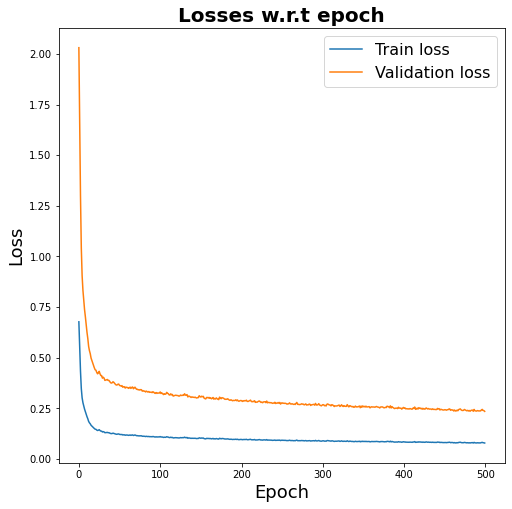

train_dice score 0.8425658345222473
test_dice score 0.8052859008312225


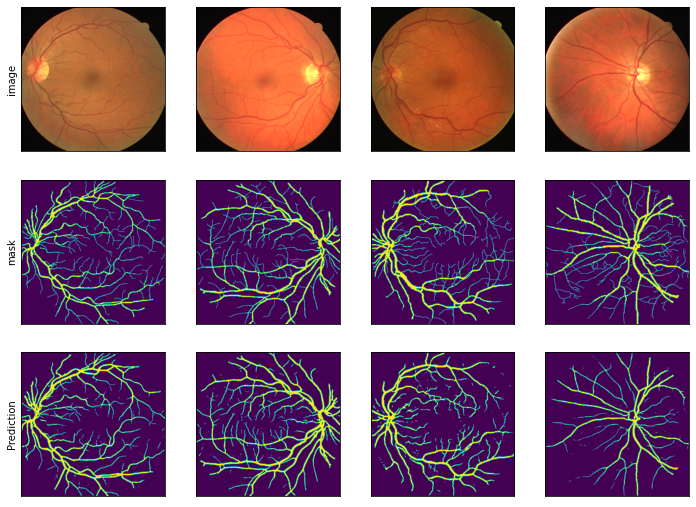

In [ ]:
torch.cuda.empty_cache()
show_image(UNet_v1, 'result/CL_AttUNet/UNET.pth', dataset = 'test')

In [ ]:
checkpoint = torch.load( drive / 'result/CL_AttUNet/UNET.pth')
device = 'cuda'
model_trained = UNet_v1(nclass=1).to(device)
model_trained.load_state_dict(checkpoint['model'])
losses_train = checkpoint['losses_train']
losses_val = checkpoint['losses_val']

Train(UNet_v1, 'result/CL_AttUNet/UNET_Cont.pth')

Start Training...


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.2211612711350123
Validation loss: 0.6634838134050369
Training loss: 0.14918517072995505
Validation loss: 0.4475555121898651
Training loss: 0.13307076195875803
Validation loss: 0.3992122858762741
Training loss: 0.12475511183341344
Validation loss: 0.3742653355002403
Training loss: 0.12255315979321797
Validation loss: 0.36765947937965393
Training loss: 0.11774840454260509
Validation loss: 0.35324521362781525
Training loss: 0.11753378808498383
Validation loss: 0.3526013642549515
Training loss: 0.11242514103651047
Validation loss: 0.3372754231095314
Training loss: 0.10965493569771449
Validation loss: 0.32896480709314346
Training loss: 0.10818857202927272
Validation loss: 0.32456571608781815
Training loss: 0.10767556230227153
Validation loss: 0.3230266869068146
Training loss: 0.10479408502578735
Validation loss: 0.31438225507736206
Training loss: 0.10474671920140584
Validation loss: 0.31424015760421753
Training loss: 0.10215847939252853
Validation loss: 0.3064754381775856
T

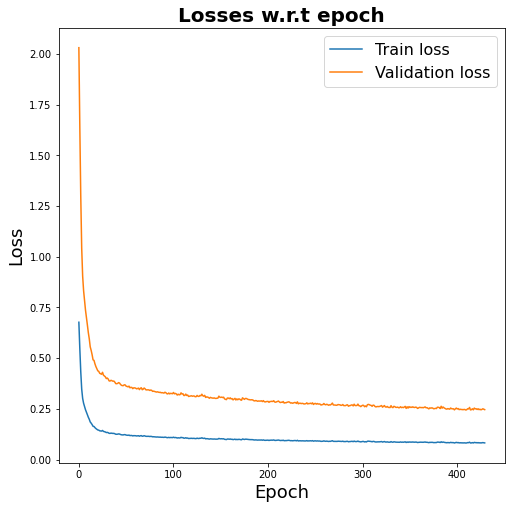

train_dice score 0.8352366089820862
test_dice score 0.8030789852142334


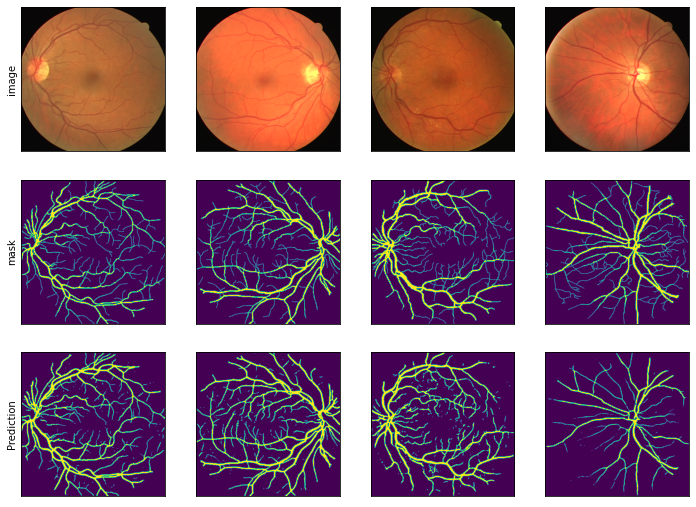

In [ ]:
show_image(UNet_v1, 'result/CL_AttUNet/UNET_Cont.pth', dataset = 'test')

In [11]:
#Train_batch_size, test_batch_size = 3
Train(UNet_v1, 'result/CL_AttUNet/UNET_bz3.pth')

Start Training...


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.16244251430034637
Validation loss: 0.40610628575086594
Training loss: 0.1355281203985214
Validation loss: 0.33882030099630356
Training loss: 0.12444905638694763
Validation loss: 0.3111226409673691
Training loss: 0.11868642419576644
Validation loss: 0.2967160604894161
Training loss: 0.11483710408210754
Validation loss: 0.28709276020526886
Training loss: 0.11550944149494172
Validation loss: 0.2887736037373543
Training loss: 0.11053952127695084
Validation loss: 0.2763488031923771
Training loss: 0.10586494952440262
Validation loss: 0.26466237381100655
Training loss: 0.10293483287096024
Validation loss: 0.2573370821774006
Training loss: 0.10076467394828796
Validation loss: 0.2519116848707199
Training loss: 0.09911217987537384
Validation loss: 0.2477804496884346
Training loss: 0.09762037843465805
Validation loss: 0.24405094608664513
Training loss: 0.09629627466201782
Validation loss: 0.24074068665504456
Training loss: 0.0954643189907074
Validation loss: 0.2386607974767685
Tr

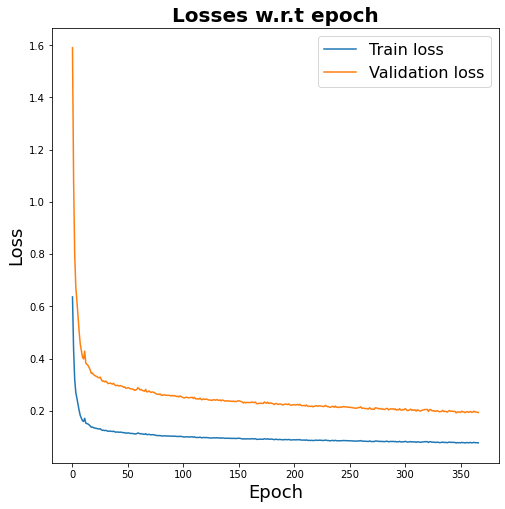

train_dice score 0.8351905703544616
test_dice score 0.8033652514219284


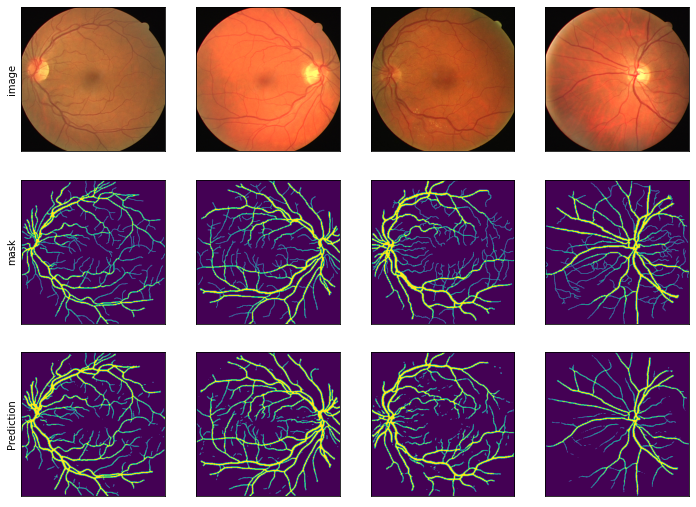

In [12]:
show_image(UNet_v1, 'result/CL_AttUNet/UNET_bz3.pth', dataset = 'test')

# Attention

## Attention U-Net

### Attention Block

In [16]:
class Attention_block(nn.Module):  # for Attention U-Net
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(F_int)
        )

        self.last = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        out = self.relu(g1 + x1)
        out = self.last(out)

        return x * out

In [17]:
class AttU_Net(nn.Module):

    def __init__(self, nchannel=3, nclass=1):
        super(AttU_Net, self).__init__()
        self.iput = self.conv(nchannel, 64)
        self.maxpool = torch.nn.MaxPool2d(2)
        self.enc1 = self.conv(64, 128)
        self.enc2 = self.conv(128, 256)
        self.enc3 = self.conv(256, 512)
        self.enc4 = self.conv(512, 1024 // 2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv(1024, 512 // 2)
        self.dec2 = self.conv(512, 256 // 2)
        self.dec3 = self.conv(256, 128 // 2)
        self.dec4 = self.conv(128, 64)
        self.oput = torch.nn.Conv2d(64, nclass, kernel_size=1)

        self.Att5 = Attention_block(512, 512, 256)
        self.Att4 = Attention_block(256, 256, 128)
        self.Att3 = Attention_block(128, 128, 64)
        self.Att2 = Attention_block(64, 64, 32)

    def forward(self, x):
        x1 = self.iput(x)  # input
        # encoder layers
        x2 = self.maxpool(x1)
        x2 = self.enc1(x2)
        x3 = self.maxpool(x2)
        x3 = self.enc2(x3)
        x4 = self.maxpool(x3)
        x4 = self.enc3(x4)
        x5 = self.maxpool(x4)
        x5 = self.enc4(x5)
        # decoder layers with skip connections and attention gates
        x = self.upsample(x5)
        x4 = self.Att5(x,x4)
        x = torch.cat([x, x4], dim=1)

        x = self.dec1(x)
        x = self.upsample(x)
        x3 = self.Att4(x, x3)
        x = torch.cat([x, x3], dim=1)

        x = self.dec2(x)
        x = self.upsample(x)
        x2 = self.Att3(x, x2)
        x = torch.cat([x, x2], dim=1)

        x = self.dec3(x)
        x = self.upsample(x)
        x1 = self.Att2(x, x1)
        x = torch.cat([x, x1], dim=1)
        
        x = self.dec4(x)
        return self.oput(x)  # output

    def conv(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True))

In [23]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

#Train_batch_size, test_batch_size = 3
Train(AttU_Net, 'result/CL_AttUNet/AttUNet.pth')

Start Training...


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.19894157946109772
Validation loss: 0.4973539486527443
Training loss: 0.1479662239551544
Validation loss: 0.36991555988788605
Training loss: 0.12728547751903535
Validation loss: 0.31821369379758835
Training loss: 0.12312280535697936
Validation loss: 0.3078070133924484
Training loss: 0.11517717242240906
Validation loss: 0.28794293105602264
Training loss: 0.11158825904130935
Validation loss: 0.2789706476032734
Training loss: 0.10767952203750611
Validation loss: 0.26919880509376526
Training loss: 0.1076035425066948
Validation loss: 0.269008856266737
Training loss: 0.10242980420589447
Validation loss: 0.2560745105147362
Training loss: 0.10045981705188751
Validation loss: 0.2511495426297188
Training loss: 0.0987922042608261
Validation loss: 0.24698051065206528
Training loss: 0.09993750154972077
Validation loss: 0.2498437538743019
Training loss: 0.0979488730430603
Validation loss: 0.24487218260765076
Training loss: 0.09556647390127182
Validation loss: 0.23891618475317955
Trai

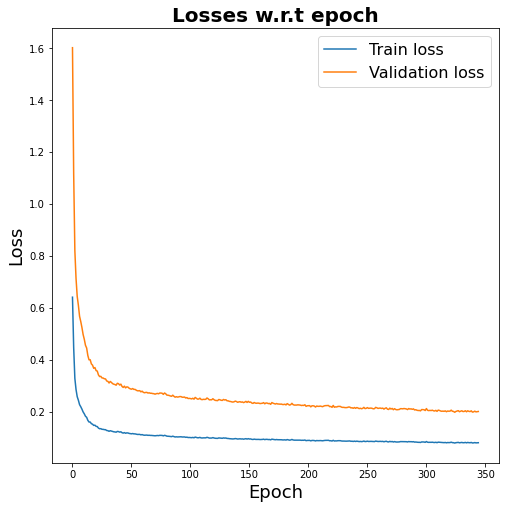

train_dice score 0.83706636428833
test_dice score 0.806671878695488


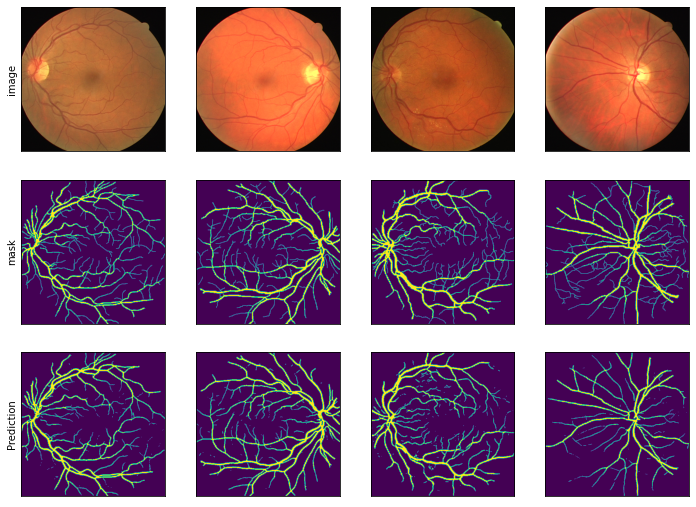

In [27]:
show_image(AttU_Net, 'result/CL_AttUNet/AttUNet.pth', dataset = 'test')

## AttU_Net with cAG

### Channel-Wise Attention Gate

In [10]:
class Channel_Attention_define(nn.Module):
    def __init__(self, num_channels, ratio=16):
        super(Channel_Attention_define, self).__init__()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.conv1 = nn.Conv2d(num_channels, num_channels // ratio, kernel_size=1)
        self.relu1 = nn.ReLU()

    def forward(self, x):
        avg_out = self.relu1(self.conv1(self.avg_pool(x)))
        max_out = self.relu1(self.conv1(self.max_pool(x)))
        out = avg_out + max_out
        return out


class Channel_Attention_gate(nn.Module):
    def __init__(self, F_g, F_l, ratio=16):
        super(Channel_Attention_gate, self).__init__()

        self.W_g = Channel_Attention_define(num_channels=F_g, ratio=ratio)

        self.W_x = Channel_Attention_define(num_channels=F_l, ratio=ratio)

        self.conv1 = nn.Conv2d(F_l // ratio, F_l, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):

        g1 = self.W_g(g)
        x1 = self.W_x(x)

        psi = self.sigmoid(self.conv1(g1 + x1))

        return psi


# class ChannelAttention(nn.Module):
#     def __init__(self, num_channels, ratio=16):
#         super(ChannelAttention, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.max_pool = nn.AdaptiveMaxPool2d(1)

#         self.fc1 = nn.Conv2d(num_channels, num_channels // ratio, kernel_size=1)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Conv2d(num_channels // ratio, num_channels, kernel_size=1)

#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
#         max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
#         out = avg_out + max_out
#         return self.sigmoid(out)

In [11]:
class AttU_Net_cAG(nn.Module):
    def __init__(self, nchannel=3, nclass=1, ratio=16):
        super(AttU_Net_cAG, self).__init__()
        self.iput = self.conv(nchannel, 64)
        self.maxpool = torch.nn.MaxPool2d(2)
        self.enc1 = self.conv(64, 128)
        self.enc2 = self.conv(128, 256)
        self.enc3 = self.conv(256, 512)
        self.enc4 = self.conv(512, 1024 // 2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv(1024, 512 // 2)
        self.dec2 = self.conv(512, 256 // 2)
        self.dec3 = self.conv(256, 128 // 2)
        self.dec4 = self.conv(128, 64)
        self.oput = torch.nn.Conv2d(64, nclass, kernel_size=1)

        self.Cha5 = Channel_Attention_gate(512, 512, ratio=ratio)
        self.Cha4 = Channel_Attention_gate(256, 256, ratio=ratio)
        self.Cha3 = Channel_Attention_gate(128, 128, ratio=ratio)
        self.Cha2 = Channel_Attention_gate(64, 64, ratio=ratio)

    def forward(self, x):
        x1 = self.iput(x)  # input
        # encoder layers
        x2 = self.maxpool(x1)
        x2 = self.enc1(x2)
        x3 = self.maxpool(x2)
        x3 = self.enc2(x3)
        x4 = self.maxpool(x3)
        x4 = self.enc3(x4)
        x5 = self.maxpool(x4)
        x5 = self.enc4(x5)
        # decoder layers with skip connections and attention gates
        x = self.upsample(x5)
        c4 = self.Cha5(x, x4)
        x4 = x4 * c4
        x = torch.cat([x, x4], dim=1)

        x = self.dec1(x)
        x = self.upsample(x)
        c3 = self.Cha4(x, x3)
        x3 = x3 * c3
        x = torch.cat([x, x3], dim=1)

        x = self.dec2(x)
        x = self.upsample(x)
        c2 = self.Cha3(x, x2)
        x2 = x2 * c2
        x = torch.cat([x, x2], dim=1)

        x = self.dec3(x)
        x = self.upsample(x)
        c1 = self.Cha2(x, x1)
        x1 = x1 * c1
        x = torch.cat([x, x1], dim=1)

        x = self.dec4(x)
        return self.oput(x)  # output

    def conv(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True))

In [12]:
Train(AttU_Net_cAG, 'result/CL_AttUNet/model_cAG.pth')

Start Training...


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.17633701860904694
Validation loss: 0.44084254652261734
Training loss: 0.13674086183309556
Validation loss: 0.3418521545827389
Training loss: 0.12517476379871367
Validation loss: 0.3129369094967842
Training loss: 0.1195783793926239
Validation loss: 0.29894594848155975
Training loss: 0.11524525284767151
Validation loss: 0.28811313211917877
Training loss: 0.11053936630487442
Validation loss: 0.27634841576218605
Training loss: 0.10972059965133667
Validation loss: 0.2743014991283417
Training loss: 0.10598834604024887
Validation loss: 0.2649708651006222
Training loss: 0.10426700413227082
Validation loss: 0.26066751033067703
Training loss: 0.10156690329313278
Validation loss: 0.25391725823283195
Training loss: 0.09916002452373504
Validation loss: 0.24790006130933762
Training loss: 0.09764902144670487
Validation loss: 0.24412255361676216
Training loss: 0.09696601033210754
Validation loss: 0.24241502583026886
Training loss: 0.0945364624261856
Validation loss: 0.2363411560654640

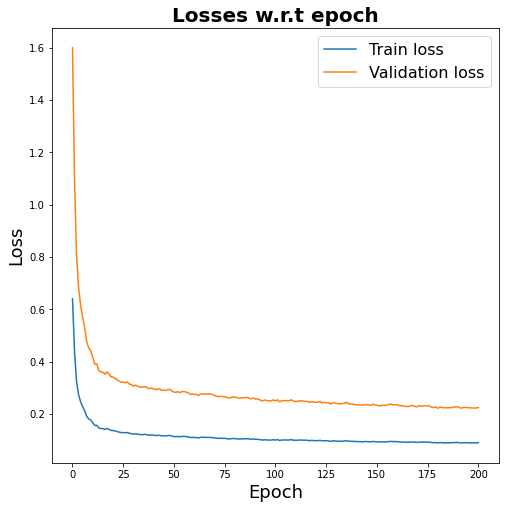

train_dice score 0.8226627707481384
test_dice score 0.8040725380182266


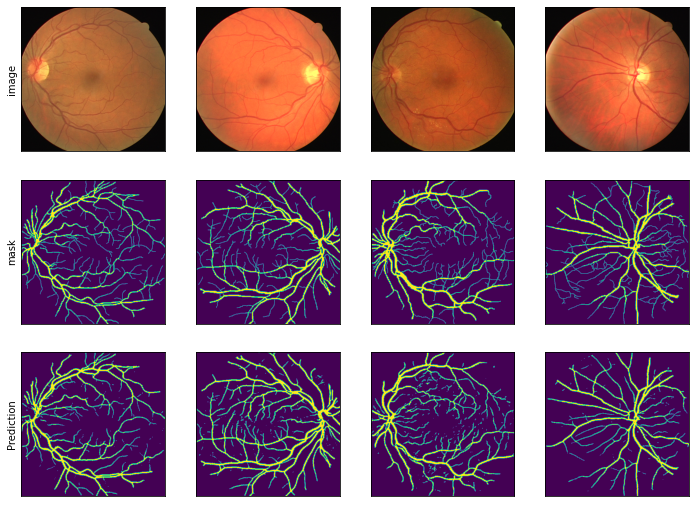

In [13]:
show_image(AttU_Net_cAG, 'result/CL_AttUNet/model_cAG.pth', dataset = 'test')


## AttU_Net with sAG

### Spatial-Wise Attention Gate

In [18]:
class Spatial_Attention_define(nn.Module):
    def __init__(self, num_channels):
        super(Spatial_Attention_define, self).__init__()

        self.conv = nn.Conv2d(3, 1, kernel_size=7, stride=1, padding=3)
        # self.conv  = nn.Conv2d(3, 1, kernel_size=3, stride=1, padding=1)
        self.conv1 = nn.Conv2d(num_channels, 1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_conv1 = self.conv1(x)
        x = torch.cat([avg_out, max_out, x_conv1], dim=1)
        psi = self.conv(x)

        return psi


class Spatial_Attention_gate(nn.Module):
    def __init__(self, F_g, F_l):
        super(Spatial_Attention_gate, self).__init__()

        self.W_g = Spatial_Attention_define(num_channels=F_g)

        self.W_x = Spatial_Attention_define(num_channels=F_l)

        self.sigmoid = nn.Sigmoid()

    def forward(self, g, x):

        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.sigmoid(g1 + x1)

        return psi
    
# class SpatialAttention(nn.Module):
#     def __init__(self, num_channels):
#         super(SpatialAttention, self).__init__()

#         self.conv = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3)
#         # self.conv = nn.Conv2d(2, 1, kernel_size=3, stride=1, padding=1)

#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         avg_out = torch.mean(x, dim=1, keepdim=True)
#         max_out, _ = torch.max(x, dim=1, keepdim=True)
#         x = torch.cat([avg_out, max_out], dim=1)
#         out = self.conv(x)
#         return self.sigmoid(out)


In [19]:
class AttU_Net_sAG(nn.Module):
    def __init__(self, nchannel=3, nclass=1):
        super(AttU_Net_sAG, self).__init__()
        self.iput = self.conv(nchannel, 64)
        self.maxpool = torch.nn.MaxPool2d(2)
        self.enc1 = self.conv(64, 128)
        self.enc2 = self.conv(128, 256)
        self.enc3 = self.conv(256, 512)
        self.enc4 = self.conv(512, 1024 // 2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv(1024, 512 // 2)
        self.dec2 = self.conv(512, 256 // 2)
        self.dec3 = self.conv(256, 128 // 2)
        self.dec4 = self.conv(128, 64)
        self.oput = torch.nn.Conv2d(64, nclass, kernel_size=1)

        self.Spa5 = Spatial_Attention_gate(512, 512)
        self.Spa4 = Spatial_Attention_gate(256, 256)
        self.Spa3 = Spatial_Attention_gate(128, 128)
        self.Spa2 = Spatial_Attention_gate(64, 64)

    def forward(self, x):
        x1 = self.iput(x)  # input
        # encoder layers
        x2 = self.maxpool(x1)
        x2 = self.enc1(x2)
        x3 = self.maxpool(x2)
        x3 = self.enc2(x3)
        x4 = self.maxpool(x3)
        x4 = self.enc3(x4)
        x5 = self.maxpool(x4)
        x5 = self.enc4(x5)
        # decoder layers with skip connections and attention gates
        x = self.upsample(x5)
        s4 = self.Spa5(x, x4)
        x4 = x4 * s4
        x = torch.cat([x, x4], dim=1)

        x = self.dec1(x)
        x = self.upsample(x)
        s3 = self.Spa4(x, x3)
        x3 = x3 * s3
        x = torch.cat([x, x3], dim=1)

        x = self.dec2(x)
        x = self.upsample(x)
        s2 = self.Spa3(x, x2)
        x2 = x2 * s2
        x = torch.cat([x, x2], dim=1)

        x = self.dec3(x)
        x = self.upsample(x)
        s1 = self.Spa2(x, x1)
        x1 = x1 * s1
        x = torch.cat([x, x1], dim=1)

        x = self.dec4(x)
        return self.oput(x)  # output

    def conv(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True))

In [12]:
Train(AttU_Net_sAG, 'result/CL_AttUNet/model_sAG.pth')

Start Training...


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.17727014124393464
Validation loss: 0.4431753531098366
Training loss: 0.13699013888835906
Validation loss: 0.3424753472208977
Training loss: 0.12692974507808685
Validation loss: 0.31732436269521713
Training loss: 0.11831862777471543
Validation loss: 0.29579656943678856
Training loss: 0.11470911353826523
Validation loss: 0.28677278384566307
Training loss: 0.11225795894861221
Validation loss: 0.28064489737153053
Training loss: 0.10849185436964034
Validation loss: 0.2712296359241009
Training loss: 0.1048084855079651
Validation loss: 0.2620212137699127
Training loss: 0.10076791942119598
Validation loss: 0.25191979855298996
Training loss: 0.10074681341648102
Validation loss: 0.25186703354120255
Training loss: 0.09999671429395676
Validation loss: 0.2499917857348919
Training loss: 0.09824471175670624
Validation loss: 0.2456117793917656
Training loss: 0.09793342351913452
Validation loss: 0.2448335587978363
Training loss: 0.09750405848026275
Validation loss: 0.2437601462006569
T

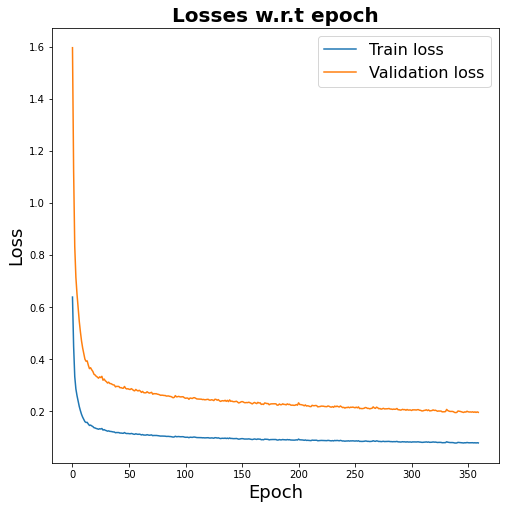

train_dice score 0.8394927382469177
test_dice score 0.8078845053911209


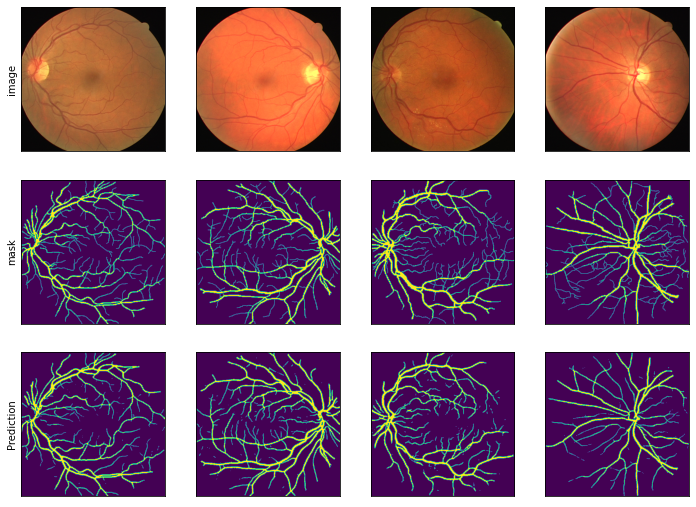

In [13]:
show_image(AttU_Net_sAG, 'result/CL_AttUNet/model_sAG.pth', dataset = 'test')

## AttU_Net with scAG

In [20]:
class AttU_Net_scAG(nn.Module):
    def __init__(self, nchannel=3, nclass=1, ratio=16):
        super(AttU_Net_scAG, self).__init__()
        self.iput = self.conv(nchannel, 64)
        self.maxpool = torch.nn.MaxPool2d(2)
        self.enc1 = self.conv(64, 128)
        self.enc2 = self.conv(128, 256)
        self.enc3 = self.conv(256, 512)
        self.enc4 = self.conv(512, 1024 // 2)
        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = self.conv(1024, 512 // 2)
        self.dec2 = self.conv(512, 256 // 2)
        self.dec3 = self.conv(256, 128 // 2)
        self.dec4 = self.conv(128, 64)
        self.oput = torch.nn.Conv2d(64, nclass, kernel_size=1)

        self.Spa5 = Spatial_Attention_gate(512, 512)
        self.Spa4 = Spatial_Attention_gate(256, 256)
        self.Spa3 = Spatial_Attention_gate(128, 128)
        self.Spa2 = Spatial_Attention_gate(64, 64)

        self.Cha5 = Channel_Attention_gate(512, 512, ratio=ratio)
        self.Cha4 = Channel_Attention_gate(256, 256, ratio=ratio)
        self.Cha3 = Channel_Attention_gate(128, 128, ratio=ratio)
        self.Cha2 = Channel_Attention_gate(64, 64, ratio=ratio)

    def forward(self, x):
        x1 = self.iput(x)  # input
        # encoder layers
        x2 = self.maxpool(x1)
        x2 = self.enc1(x2)
        x3 = self.maxpool(x2)
        x3 = self.enc2(x3)
        x4 = self.maxpool(x3)
        x4 = self.enc3(x4)
        x5 = self.maxpool(x4)
        x5 = self.enc4(x5)
        # decoder layers with skip connections and attention gates
        x = self.upsample(x5)
        s4 = self.Spa5(x, x4)
        c4 = self.Cha5(x, x4)
        x4 = (x4 * s4) * c4
        x = torch.cat([x, x4], dim=1)

        x = self.dec1(x)
        x = self.upsample(x)
        s3 = self.Spa4(x, x3)
        c3 = self.Cha4(x, x3)
        x3 = (x3 * s3) * c3
        x = torch.cat([x, x3], dim=1)

        x = self.dec2(x)
        x = self.upsample(x)
        s2 = self.Spa3(x, x2)
        c2 = self.Cha3(x, x2)
        x2 = (x2 * s2) * c2
        x = torch.cat([x, x2], dim=1)

        x = self.dec3(x)
        x = self.upsample(x)
        s1 = self.Spa2(x, x1)
        c1 = self.Cha2(x, x1)
        x1 = (x1 * s1) * c1
        x = torch.cat([x, x1], dim=1)

        x = self.dec4(x)
        return self.oput(x)  # output

    def conv(self, in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True))

In [15]:
Train(AttU_Net_scAG, 'result/CL_AttUNet/model_scAG.pth')

Start Training...


  0%|          | 0/500 [00:00<?, ?it/s]

Training loss: 0.20834411978721618
Validation loss: 0.5208602994680405
Training loss: 0.1483325481414795
Validation loss: 0.37083137035369873
Training loss: 0.128862926363945
Validation loss: 0.3221573159098625
Training loss: 0.12043147087097168
Validation loss: 0.3010786771774292
Training loss: 0.11549305766820908
Validation loss: 0.2887326441705227
Training loss: 0.1117541879415512
Validation loss: 0.279385469853878
Training loss: 0.1099533885717392
Validation loss: 0.274883471429348
Training loss: 0.1052889883518219
Validation loss: 0.26322247087955475
Training loss: 0.10284571945667267
Validation loss: 0.25711429864168167
Training loss: 0.10236305743455887
Validation loss: 0.25590764358639717
Training loss: 0.10087278634309768
Validation loss: 0.2521819658577442
Training loss: 0.09843739122152328
Validation loss: 0.2460934780538082
Training loss: 0.0964165523648262
Validation loss: 0.2410413809120655
Training loss: 0.0956507906317711
Validation loss: 0.23912697657942772
Training lo

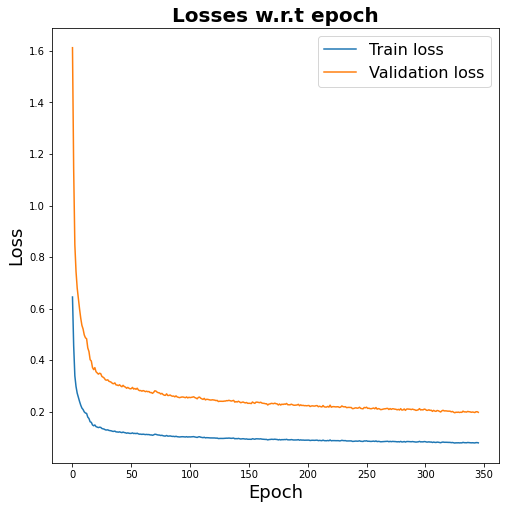

train_dice score 0.8433340191841125
test_dice score 0.8106013506650924


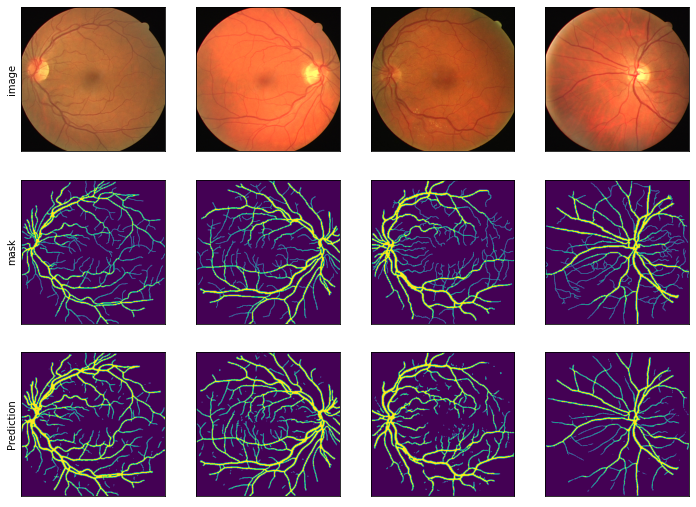

In [16]:
show_image(AttU_Net_scAG, 'result/CL_AttUNet/model_scAG.pth', dataset = 'test')

# Comparison

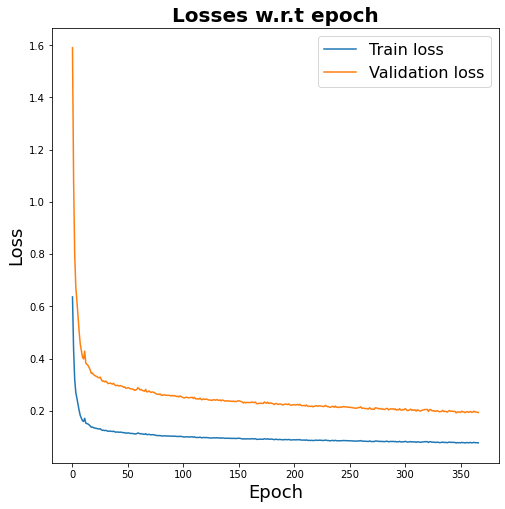

train_dice score 0.8351905703544616
test_dice score 0.8033652514219284


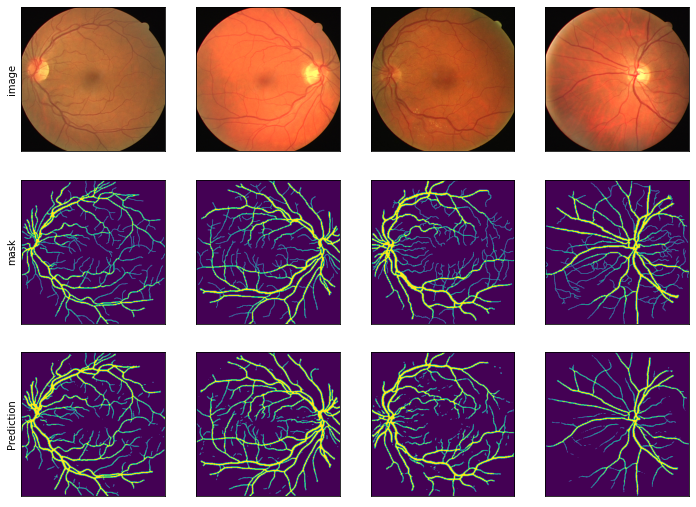

In [22]:
show_image(UNet_v1, 'result/CL_AttUNet/UNET_bz3.pth', dataset = 'test')

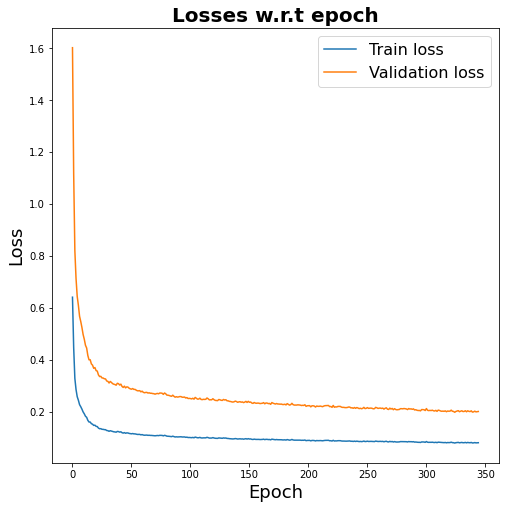

train_dice score 0.83706636428833
test_dice score 0.806671878695488


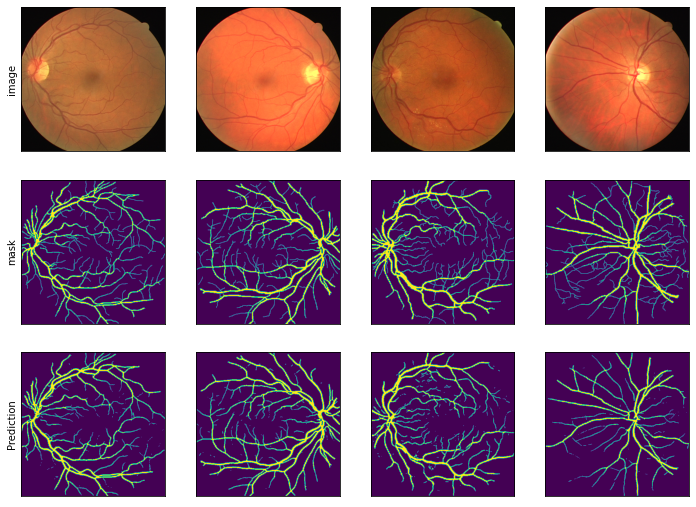

In [23]:
show_image(AttU_Net, 'result/CL_AttUNet/AttUNet.pth', dataset = 'test')

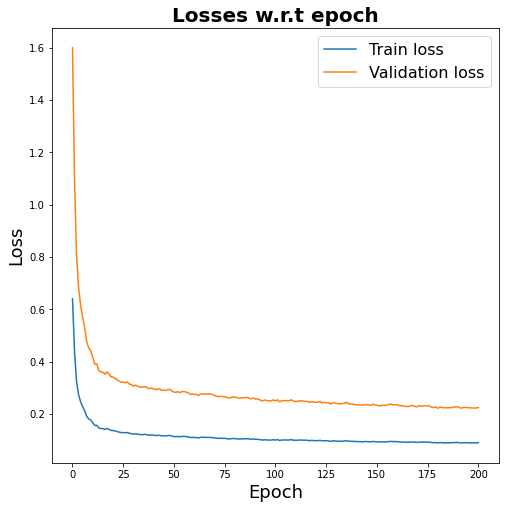

train_dice score 0.8226627707481384
test_dice score 0.8040725380182266


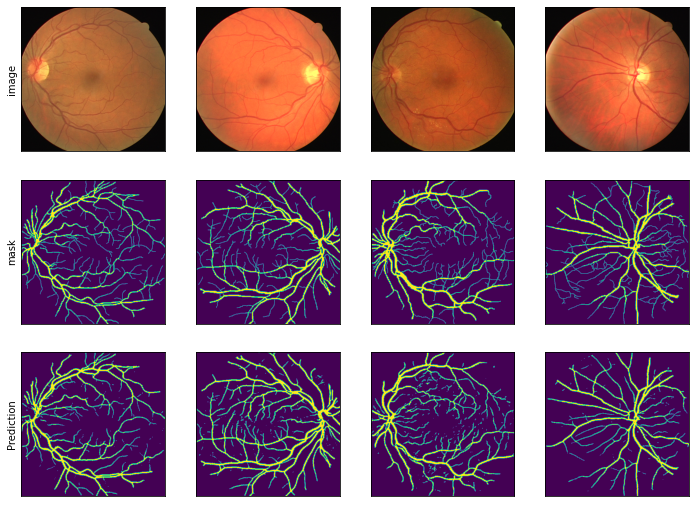

In [24]:
show_image(AttU_Net_cAG, 'result/CL_AttUNet/model_cAG.pth', dataset = 'test')

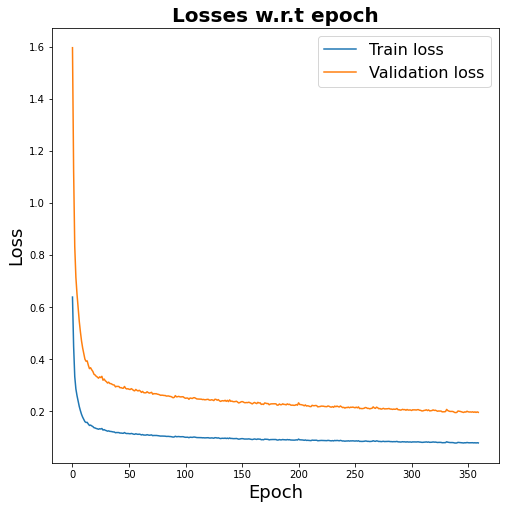

train_dice score 0.8394927382469177
test_dice score 0.8078845053911209


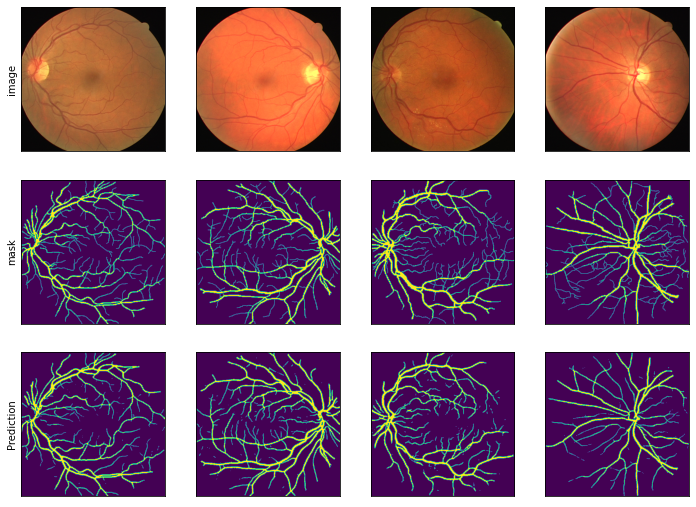

In [25]:
show_image(AttU_Net_sAG, 'result/CL_AttUNet/model_sAG.pth', dataset = 'test')

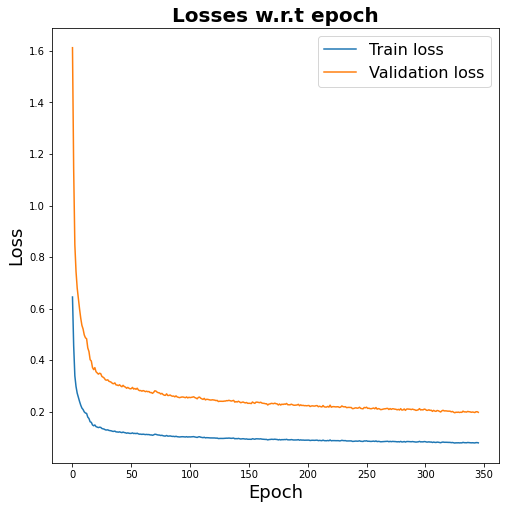

train_dice score 0.8433340191841125
test_dice score 0.8106013506650924


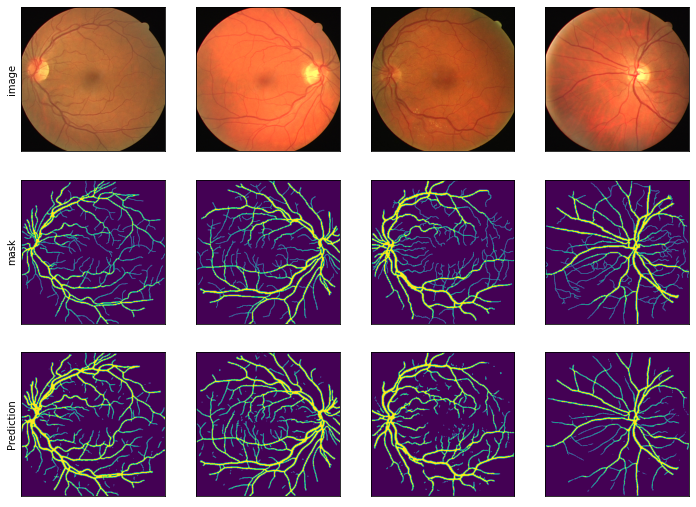

In [26]:
show_image(AttU_Net_scAG, 'result/CL_AttUNet/model_scAG.pth', dataset = 'test')